In [203]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [204]:
df = pd.read_csv('housePrice.csv')
df = df.drop_duplicates()
df["Address"] = df["Address"].fillna("Unknown")
df = pd.get_dummies(df, columns=["Address"], drop_first=True)

In [205]:
y = df["Price(USD)"]
X = df.drop(columns=["Price", "Price(USD)"])

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [207]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].str.strip().str.replace(',', '')
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].str.strip().str.replace(',', '')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')


In [208]:
# Fill any remaining NaNs with column mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())


In [209]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [210]:
# Standardize the target (Price)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [211]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [212]:
class HousePriceNN(nn.Module):
    def __init__(self, input_size):
        super(HousePriceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # first hidden layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)          # second hidden layer
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(32, 1)        # output layer

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.output(x)
        return x

In [213]:
input_size = X_train_tensor.shape[1]
model = HousePriceNN(input_size)
print(model)

HousePriceNN(
  (fc1): Linear(in_features=197, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [214]:
# Step 2: Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [215]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()              # Clear gradients
    outputs = model(X_train_tensor)    # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()                    # Backward pass
    optimizer.step()                   # Update weights

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/100], Loss: 0.9079
Epoch [20/100], Loss: 0.7541
Epoch [30/100], Loss: 0.5880
Epoch [40/100], Loss: 0.4702
Epoch [50/100], Loss: 0.4018
Epoch [60/100], Loss: 0.3748
Epoch [70/100], Loss: 0.3518
Epoch [80/100], Loss: 0.3313
Epoch [90/100], Loss: 0.3127
Epoch [100/100], Loss: 0.2965


In [216]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f"Test MSE Loss (normalized): {test_loss.item():.4f}")

    # Inverse transform predictions to original scale
    predictions_real = y_scaler.inverse_transform(predictions.numpy())
    y_test_real = y_scaler.inverse_transform(y_test_tensor.numpy())

    # Print a few example predictions
    for i in range(5):
        actual = y_test_real[i][0]
        predicted = predictions_real[i][0]
        print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")


Test MSE Loss (normalized): 0.3030
Actual: 41666.67, Predicted: 70724.72
Actual: 51000.00, Predicted: 91374.67
Actual: 312000.00, Predicted: 284413.91
Actual: 61666.67, Predicted: 35596.58
Actual: 63333.33, Predicted: 109027.36


In [217]:
mse = mean_squared_error(y_test_real, predictions_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_real, predictions_real)
r2 = r2_score(y_test_real, predictions_real)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 70241.19
Root Mean Squared Error (RMSE): 154109.33
R-squared (R²): 0.6287


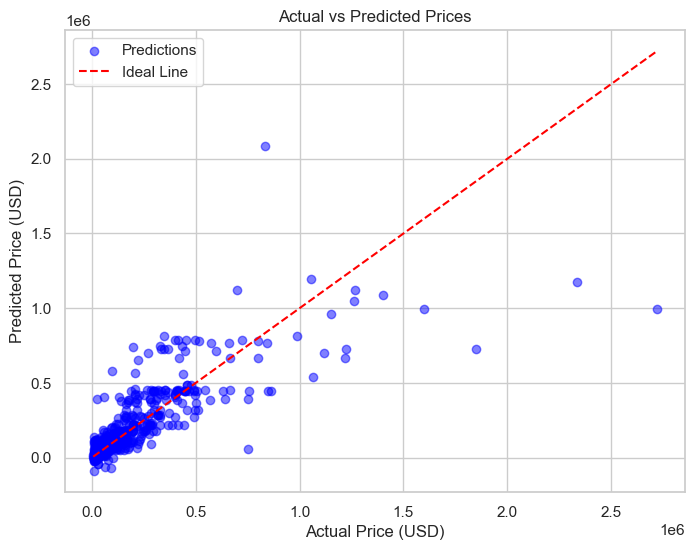

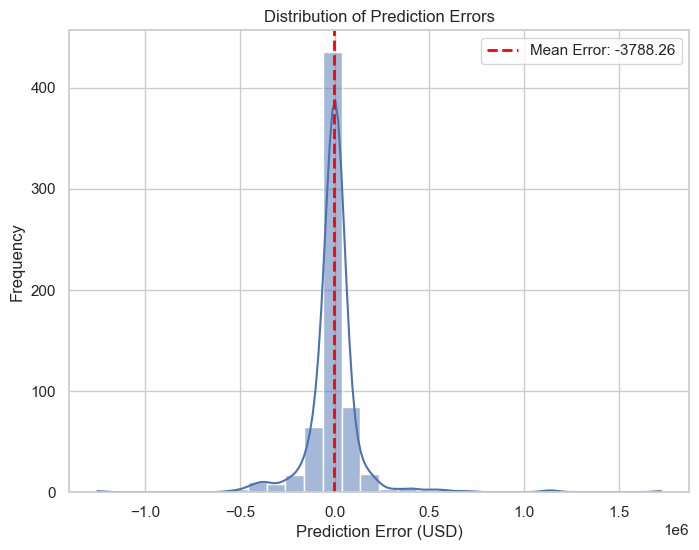

In [218]:
sns.set(style="whitegrid")

# نمودار پراکندگی (Actual vs. Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, predictions_real, alpha=0.5, color="blue", label="Predictions")
plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], color='red', linestyle='--', label="Ideal Line")
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()

# هیستوگرام خطاها (Residuals)
errors = y_test_real - predictions_real
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color="purple")
plt.axvline(errors.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean Error: {errors.mean():.2f}")
plt.xlabel("Prediction Error (USD)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.legend()
plt.show()